In [1]:
import numpy as np
import pandas as pd

# Load training data
X_train = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/features/cluster_features.csv')
y_train = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/labels/labels.npy')

# Load validation data
X_val = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/features/cluster_features.csv')
y_val = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/labels/labels.npy')

# Load test data (no labels)
X_test = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/features/cluster_features.csv')
test_ids = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/ids/ids.npy')


In [2]:
# Check shape and first few rows
print("Training set:", X_train.shape, "Validation set:", X_val.shape)
X_train.head()

Training set: (3520, 14) Validation set: (502, 14)


,n_clusters,max_cluster_pt,mean_cluster_pt,std_cluster_pt,max_cluster_size,mean_cluster_size,std_cluster_size,total_pt,max_cluster_eta,max_cluster_phi,mean_cluster_eta,mean_cluster_phi,cluster_pt_ratio,cluster_size_ratio
0,13,2.0,0.615318,0.539951,2,2.0,0.0,7.999129,0.5,0.7,0.076923,0.346154,1.470200,1.0
1,10,2.0,0.777020,0.601157,2,2.0,0.0,7.770204,0.2,0.5,0.100000,0.230000,1.430785,1.0
2,4,2.0,0.972718,0.606990,2,2.0,0.0,3.890871,0.1,0.1,0.050000,0.050000,2.557882,1.0
3,14,2.0,0.746367,0.485636,2,2.0,0.0,10.449135,0.5,0.5,0.185714,0.285714,1.624096,1.0
4,6,2.0,0.575760,0.639069,2,2.0,0.0,3.454561,0.1,0.1,0.050000,0.066667,4.988196,1.0


# EDA

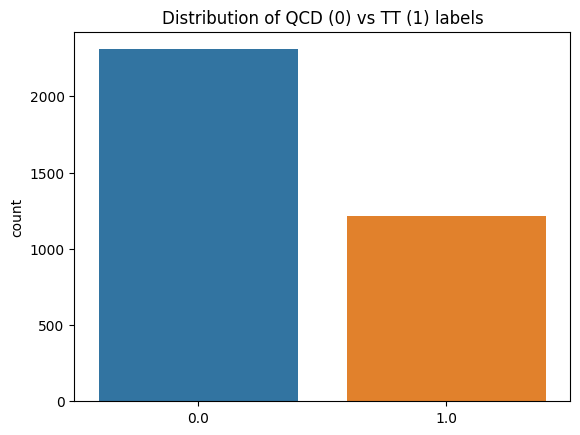

In [3]:
# Distribution of target labels
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)
plt.title("Distribution of QCD (0) vs TT (1) labels")
plt.show()


In [4]:
# Summary statistics of features
X_train.describe()


,n_clusters,max_cluster_pt,mean_cluster_pt,std_cluster_pt,max_cluster_size,mean_cluster_size,std_cluster_size,total_pt,max_cluster_eta,max_cluster_phi,mean_cluster_eta,mean_cluster_phi,cluster_pt_ratio,cluster_size_ratio
count,3520.000000,3520.0,3520.000000,3520.000000,3520.0,3520.0,3520.0,3520.000000,3520.000000,3520.000000,3520.000000,3520.000000,3520.000000,3520.0
mean,5.416477,2.0,1.038647,0.609220,2.0,2.0,0.0,5.002839,0.158267,0.376420,0.064213,0.170904,2.092187,1.0
std,3.304799,0.0,0.304997,0.153745,0.0,0.0,0.0,2.209156,0.134055,0.296394,0.045809,0.143662,1.403356,0.0
min,1.000000,2.0,0.485383,0.000000,2.0,2.0,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,3.000000,2.0,0.823177,0.561929,2.0,2.0,0.0,3.432652,0.100000,0.100000,0.037500,0.050000,1.216944,1.0
50%,5.000000,2.0,0.975872,0.631766,2.0,2.0,0.0,4.509195,0.100000,0.300000,0.050000,0.115476,1.612840,1.0
75%,7.000000,2.0,1.188014,0.694910,2.0,2.0,0.0,6.101755,0.200000,0.700000,0.080000,0.283333,2.343329,1.0
max,28.000000,2.0,2.000000,0.899472,2.0,2.0,0.0,17.998972,1.100000,1.200000,0.440000,0.660000,9.947500,1.0


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


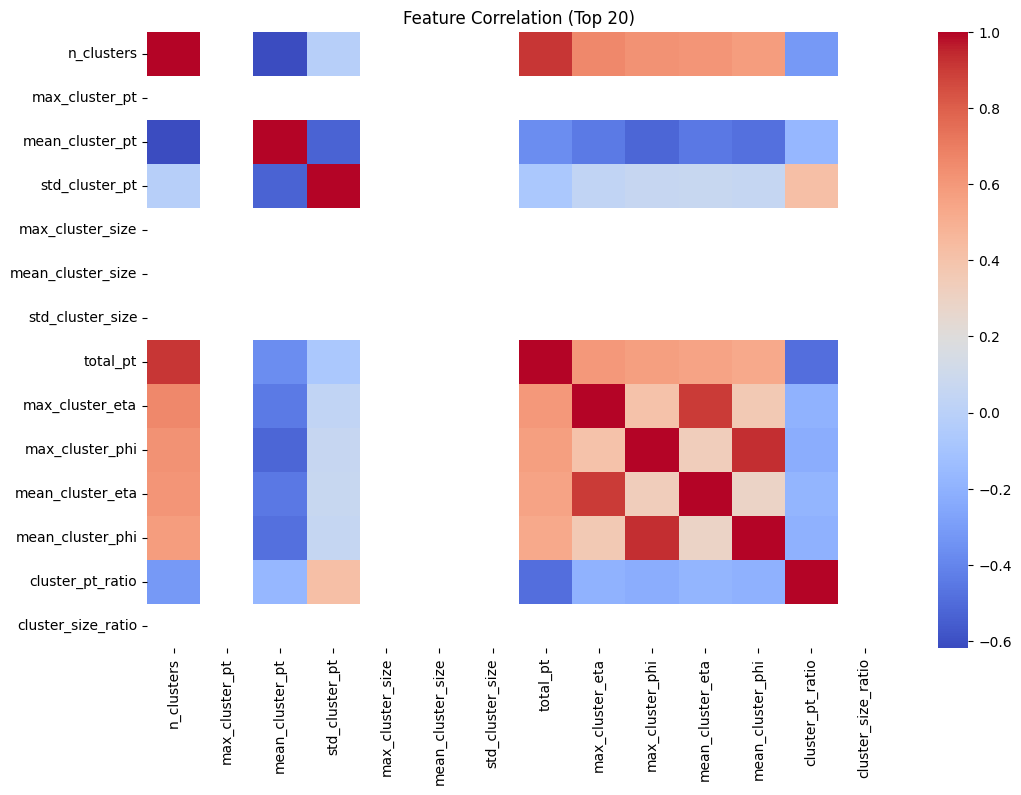

In [5]:
# Correlation matrix (top features)
corr = X_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr.iloc[:20, :20], cmap='coolwarm', annot=False)
plt.title("Feature Correlation (Top 20)")
plt.show()


# Logistic Regression Baseline

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Standardize features for logistic regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test) 

# Train the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict on validation set
val_preds = logreg.predict_proba(X_val_scaled)[:, 1]
auc_score = roc_auc_score(y_val, val_preds)

print(f"Validation AUC for Logistic Regression: {auc_score:.4f}")


Validation AUC for Logistic Regression: 0.9444


In [7]:
# Saving validation set predictions
np.save('/kaggle/working/lr_val_preds.npy', val_preds)

In [8]:
# Predict probabilities on test set
test_preds = logreg.predict_proba(scaler.transform(X_test))[:, 1]

# Saving test set predictions
np.save('/kaggle/working/lr_test_preds.npy', test_preds)

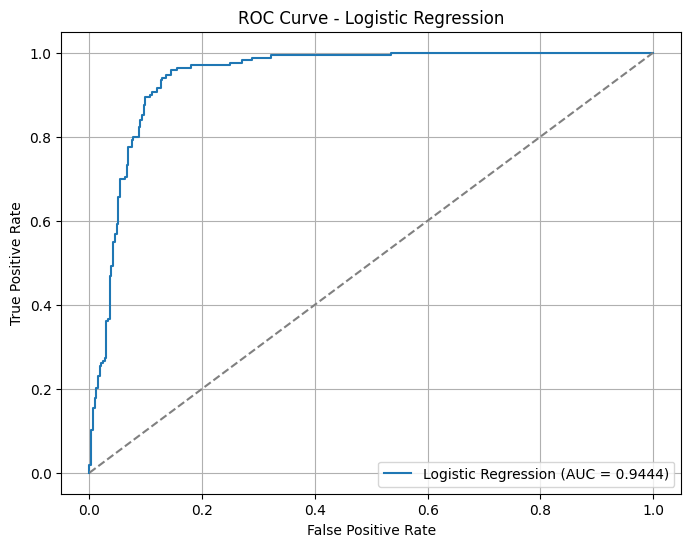

In [9]:
from sklearn.metrics import roc_curve

# Compute false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_val, val_preds)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


# Feature Importance - Logistic Regression

In [10]:
# Create a DataFrame of feature coefficients
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': logreg.coef_[0]
})

# Add absolute value for sorting
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()

# Sort by absolute importance
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Display top 15 important features
feature_importance.head(15)


,feature,coefficient,abs_coefficient
0,n_clusters,-2.107316,2.107316
11,mean_cluster_phi,1.582809,1.582809
7,total_pt,1.266147,1.266147
9,max_cluster_phi,1.214763,1.214763
2,mean_cluster_pt,-0.592721,0.592721
3,std_cluster_pt,-0.544767,0.544767
10,mean_cluster_eta,0.205665,0.205665
12,cluster_pt_ratio,0.167929,0.167929
8,max_cluster_eta,0.144155,0.144155
1,max_cluster_pt,0.000000,0.000000


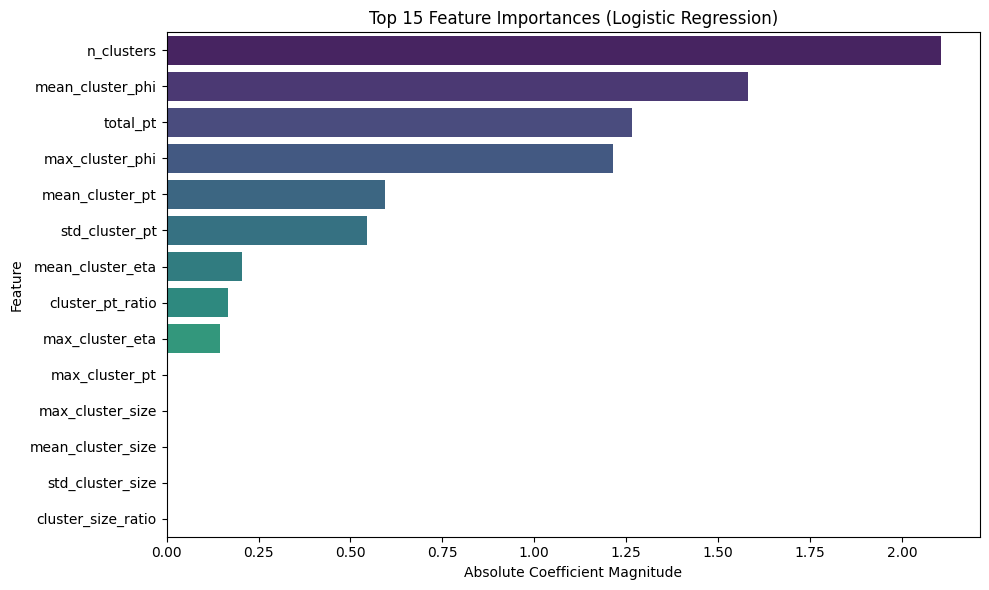

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='abs_coefficient', y='feature', palette='viridis')
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.xlabel("Absolute Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# XGBoost

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Initialize and train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict probabilities on validation set
val_preds_xgb = xgb.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_xgb = roc_auc_score(y_val, val_preds_xgb)
print(f"Validation AUC (XGBoost): {auc_xgb:.4f}")


Validation AUC (XGBoost): 0.9341


In [13]:
np.save("xgb_val_preds.npy", val_preds_xgb)

In [14]:
test_xgb_preds = xgb.predict_proba(X_test)[:, 1]
np.save('/kaggle/working/xgb_test_preds.npy', test_xgb_preds)

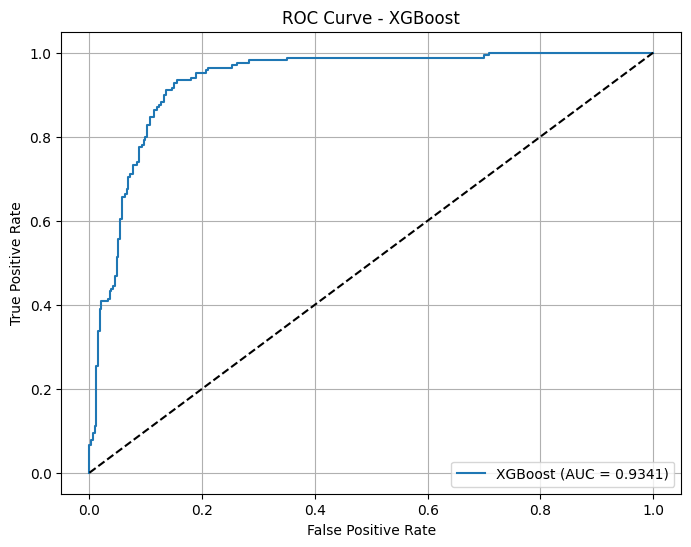

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_xgb, tpr_xgb, _ = roc_curve(y_val, val_preds_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


# Feature Importance - XGBoost

In [16]:
# Get feature importances
importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(15)


,feature,importance
9,max_cluster_phi,0.424666
11,mean_cluster_phi,0.299685
0,n_clusters,0.073792
10,mean_cluster_eta,0.038939
12,cluster_pt_ratio,0.036753
3,std_cluster_pt,0.033599
2,mean_cluster_pt,0.033200
7,total_pt,0.030425
8,max_cluster_eta,0.028941
1,max_cluster_pt,0.000000


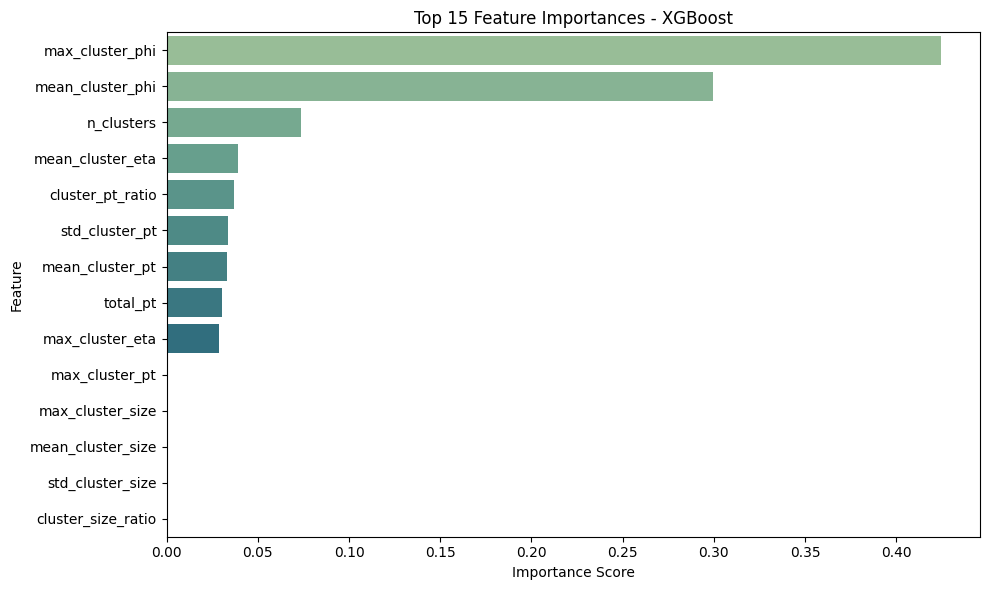

In [17]:
#feature importance plot

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature', palette='crest')
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Generating Feature Interaction

In [18]:
# Get original XGBoost feature importances
importances = xgb.feature_importances_
top_k = 20  # You can adjust this number

important_features = pd.Series(importances, index=X_train.columns)
important_features = important_features.sort_values(ascending=False).head(top_k).index.tolist()

# Subset training and validation sets
X_train_top = X_train[important_features]
X_val_top = X_val[important_features]


In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_top)
X_val_poly = poly.transform(X_val_top)


print("New shape with interactions:", X_train_poly.shape)

New shape with interactions: (3520, 105)


# Tuned XGBoost

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_poly = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_poly.fit(
    X_train_poly, y_train,
    eval_set=[(X_val_poly, y_val)],
    early_stopping_rounds=20,
    verbose=False
)


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

val_preds_poly = xgb_poly.predict_proba(X_val_poly)[:, 1]
auc_poly = roc_auc_score(y_val, val_preds_poly)
print(f"🔁 XGBoost + Top-{top_k} Interactions AUC: {auc_poly:.4f}")

🔁 XGBoost + Top-20 Interactions AUC: 0.9436


In [22]:
np.save("tunedxgb_val_preds.npy", val_preds_poly)  # or xgb_interaction_preds, depending on your best model


In [23]:
# Step 1: Get test set with same top 20 features
X_test_top = X_test[important_features]

# Step 2: Apply same PolynomialFeatures transformer
X_test_poly = poly.transform(X_test_top)

# Step 3: Predict using xgb_poly
test_xgb_tuned_preds = xgb_poly.predict_proba(X_test_poly)[:, 1]

# Step 4: Save predictions
np.save('/kaggle/working/xgb_tuned_test_preds.npy', test_xgb_tuned_preds)


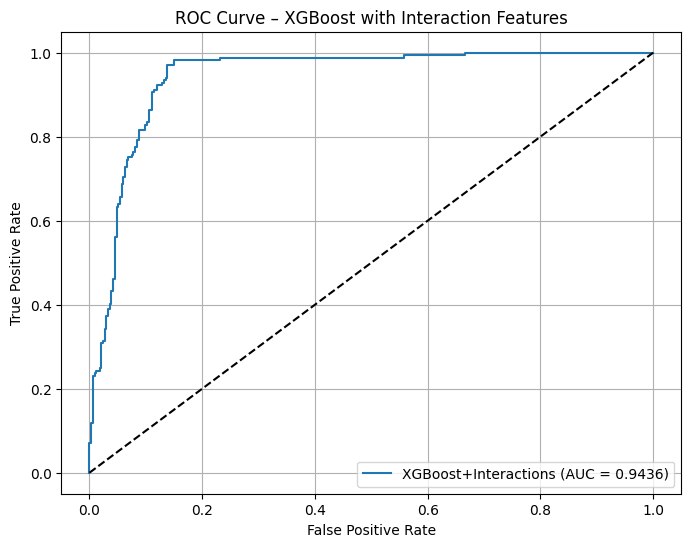

In [24]:
fpr, tpr, _ = roc_curve(y_val, val_preds_poly)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost+Interactions (AUC = {auc_poly:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost with Interaction Features")
plt.legend()
plt.grid(True)
plt.show()

# DEEP NEURAL NETWORK (DNN)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build DNN
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile
dnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')

# Train
history = dnn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


2025-06-19 05:59:25.060061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750312765.326248      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750312765.393094      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-19 05:59:40.152123: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - AUC: 0.7953 - loss: 0.5865 - val_AUC: 0.9241 - val_loss: 0.3393
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9176 - loss: 0.3450 - val_AUC: 0.9415 - val_loss: 0.2770
Epoch 3/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9197 - loss: 0.3265 - val_AUC: 0.9435 - val_loss: 0.2697
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9295 - loss: 0.3042 - val_AUC: 0.9437 - val_loss: 0.2659
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9367 - loss: 0.2956 - val_AUC: 0.9449 - val_loss: 0.2652
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9368 - loss: 0.2937 - val_AUC: 0.9440 - val_loss: 0.2669
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9357 - loss: 0.2941 - val_AUC: 0.9438 - val_loss: 0.2682
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9337 - loss: 0.2977 - val_AUC: 0.9440 - val_loss: 0.2651
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9345 - loss: 0.2987 - val_AUC: 0.9446 - val_loss: 0.2662
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9422 - loss: 0.2741 - val_AUC: 0.9441 - val_loss: 0.2669
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9413 - loss: 0

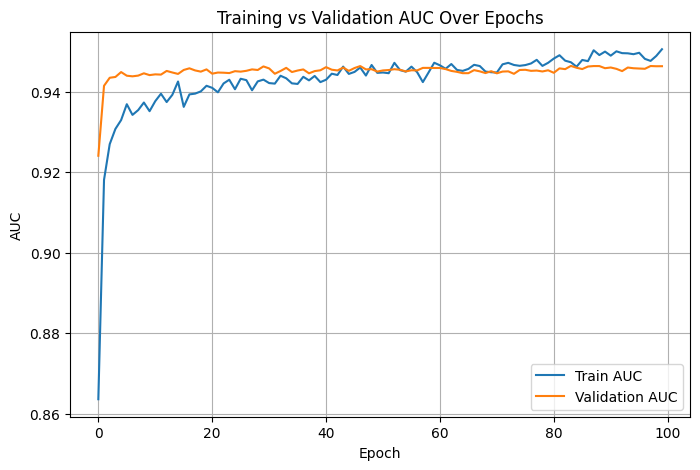

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation AUC
plt.figure(figsize=(8, 5))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Training vs Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print(history.history.keys())


dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Best Model: DNN | Validation AUC: 0.9464


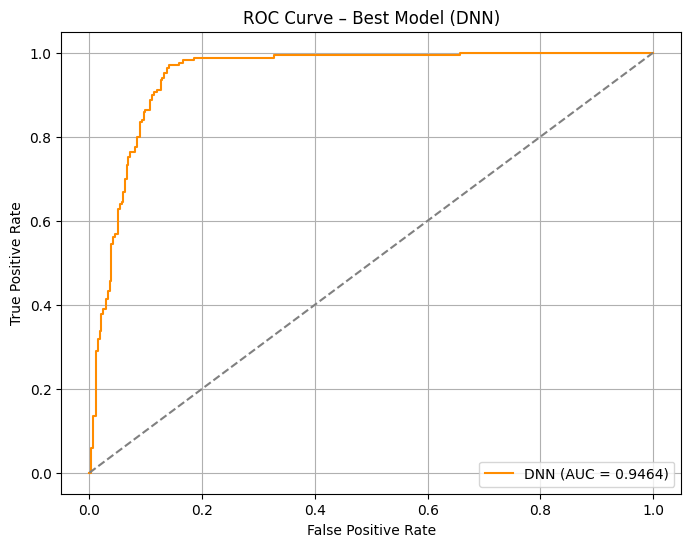

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities on validation set
val_preds_dnn = dnn.predict(X_val_scaled).flatten()

# Compute ROC AUC
auc_dnn = roc_auc_score(y_val, val_preds_dnn)
print(f"✅ Best Model: DNN | Validation AUC: {auc_dnn:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, val_preds_dnn)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'DNN (AUC = {auc_dnn:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model (DNN)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
np.save('/kaggle/working/dnn_preds.npy', val_preds_dnn)

In [31]:
test_dnn_preds = dnn.predict(X_test, batch_size=512).flatten()
np.save('/kaggle/working/dnn_test_preds.npy', test_dnn_preds)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [32]:
# Load the saved numpy array
loaded_preds = np.load("dnn_preds.npy")

# Check first few values
print(loaded_preds[:10])

# Optional: Check shape and data type
print("Shape:", loaded_preds.shape)
print("Data type:", loaded_preds.dtype)


[0.9447554  0.88167626 0.31414437 0.02150253 0.7538249  0.59998375
 0.5121375  0.00899143 0.7381581  0.48497993]
Shape: (502,)
Data type: float32


# Model Ensembling - LR + BDT + DNN

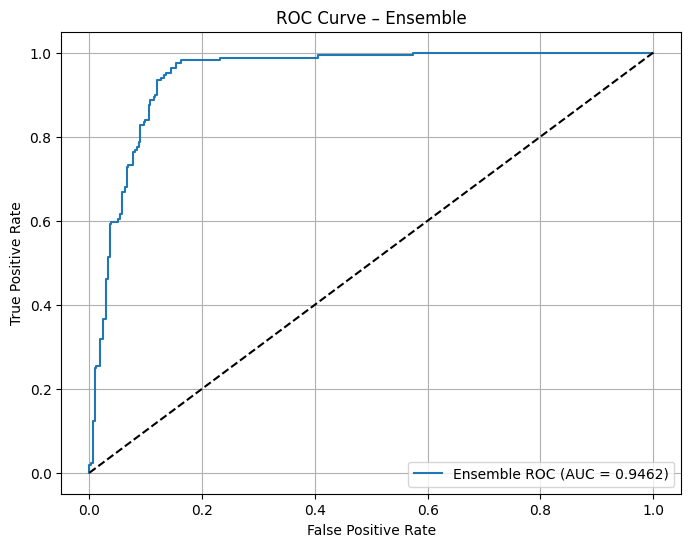

0.9461947154254847

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Simulated prediction data from top 3 models
lr_preds = np.load('/kaggle/working/lr_val_preds.npy')
xgb_preds = np.load('/kaggle/working/xgb_val_preds.npy')
dnn_preds = np.load('/kaggle/working/dnn_preds.npy')

# Load ground truth for validation
y_val = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/labels/labels.npy')

# Define ensemble weights (you can tune these)
weights = [0.2, 0.3, 0.5]  # LR, XGB, DNN

# Ensemble prediction (weighted average)
ensemble_preds = weights[0] * lr_preds + weights[1] * xgb_preds + weights[2] * dnn_preds

# Evaluate AUC
ensemble_auc = roc_auc_score(y_val, ensemble_preds)

# Plot ROC
fpr, tpr, _ = roc_curve(y_val, ensemble_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC = {ensemble_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Ensemble")
plt.legend()
plt.grid(True)
plt.show()

ensemble_auc


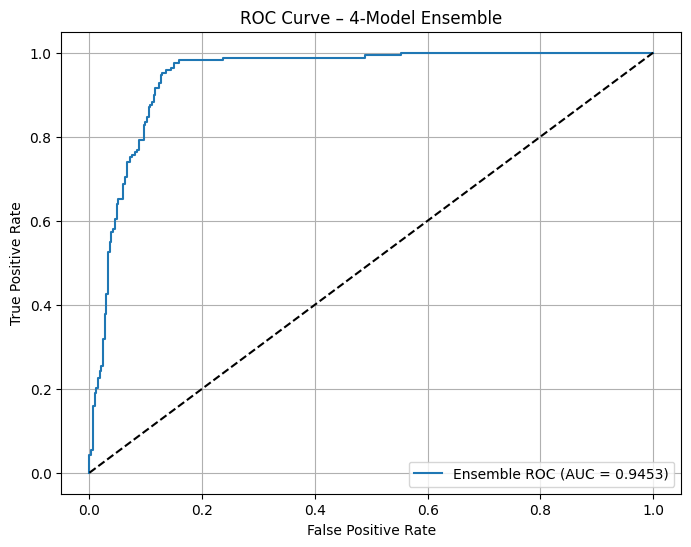

0.9452529452529452

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load validation predictions
lr_preds = np.load('/kaggle/working/lr_val_preds.npy')
xgb_preds = np.load('/kaggle/working/xgb_val_preds.npy')
xgb_tuned_preds = np.load('/kaggle/working/tunedxgb_val_preds.npy')
dnn_preds = np.load('/kaggle/working/dnn_preds.npy')

# Load validation labels
y_val = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/labels/labels.npy')

# Ensemble with simple average (equal weights)
ensemble_preds = (lr_preds + xgb_preds + xgb_tuned_preds + dnn_preds) / 4

# AUC Score
ensemble_auc = roc_auc_score(y_val, ensemble_preds)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, ensemble_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC = {ensemble_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – 4-Model Ensemble")
plt.legend()
plt.grid(True)
plt.show()

ensemble_auc


In [35]:
import numpy as np
import pandas as pd

# Load test predictions from all models
lr_test_preds = np.load('/kaggle/working/lr_test_preds.npy')
xgb_test_preds = np.load('/kaggle/working/xgb_test_preds.npy')
xgb_tuned_test_preds = np.load('/kaggle/working/xgb_tuned_test_preds.npy')
dnn_test_preds = np.load('/kaggle/working/dnn_test_preds.npy')

# Load test IDs
test_ids = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/ids/ids.npy')

# Simple average ensemble
ensemble_test_preds = (lr_test_preds + xgb_test_preds + xgb_tuned_test_preds + dnn_test_preds) / 4

# Create submission DataFrame with correct header
submission = pd.DataFrame({
    'id': test_ids,
    'label': ensemble_test_preds  # MUST be named 'label'
})

# Save as CSV without index
submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Submission file 'submission.csv' is ready.")


Submission file 'submission.csv' is ready.
